In [247]:
import json
import os
from itertools import product
from pathlib import Path
from typing import List, Tuple, Union

import corner
import jax
import jax.numpy as jnp
import keras
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import tensorflow as tf
from keras import layers
from sklearn.decomposition import PCA
from tensorflow.keras.models import Model

In [248]:
class PCANN(tf.keras.layers.Layer):
    """
    Inverse PCA layer for tensorflow neural network

    Usage:
        - Define dictionary of custom objects containing Inverse PCA
        - Use arguments of PCA mean and components from PCA of output parameters for inverse PCA (found in JSON dict)

    Example:

    > f = open("pcann_info.json")
    >
    > data = json.load(f)
    >
    > pca_comps = np.array(data["pca_comps"])
    > pca_mean = np.array(data["pca_mean"])
    >
    > custom_objects = {"InversePCA": InversePCA(pca_comps, pca_mean)}
    > pcann_model = tf.keras.models.load_model("pcann_name.h5", custom_objects=custom_objects)

    """

    def __init__(self, pca_comps, pca_mean, **kwargs):
        super(PCANN, self).__init__()
        self.pca_comps = pca_comps
        self.pca_mean = pca_mean

    def call(self, x):
        y = tf.tensordot(x, np.float32(self.pca_comps), 1) + np.float32(self.pca_mean)
        return y

    def get_config(self):
        config = super().get_config().copy()
        config.update({"pca_comps": self.pca_comps, "pca_mean": self.pca_mean})
        return config
    

class WMSE(tf.keras.losses.Loss):
    """
    Weighted Mean Squared Error Loss Function for tensorflow neural network

    Usage:
        - Define list of weights with len = labels
        - Use weights as arguments - no need to square, this is handled in-function
        - Typical usage - defining target precision on outputs for the network to achieve, weights parameters in loss calculation to force network to focus on parameters with unc >> weight.

    """

    def __init__(self, weights, name="WMSE", **kwargs):
        super(WMSE, self).__init__()
        self.weights = np.float32(weights)

    def call(self, y_true, y_pred):
        loss = ((y_true - y_pred) / (self.weights)) ** 2
        return tf.math.reduce_mean(loss)

    def get_config(self):
        config = super().get_config().copy()
        config.update({"weights": self.weights})
        return config


def WMSE_metric(y_true, y_pred):
    metric = ((y_true - y_pred) / (weights)) ** 2
    return tf.reduce_mean(metric)

In [249]:
run_name = "smiley_stingray"

In [250]:
emulatorpath = f"./{run_name}/"

logfile = f"log_{run_name}.json"
pcafile = f"pca_{run_name}.json"
checkpointfile = f"{run_name}_checkpoint.h5"
historyfile = f"history_{run_name}.json"

with open(os.path.join(emulatorpath, logfile), "r") as fp:
    data = json.load(fp)

    gridpath = data["gridpath"]
    gridfile = data["gridfile"]
    grid = os.path.join(gridpath, gridfile)

    seed = data["seed"]
    n_components = data["n_components"]

    batch_size_exp = data["batch_size_exp"]
    epochs = data["epochs"]
    test_size = data["test_size"]
    fractrain = data["fractrain"]

    inputs = data["inputs"]
    classical_outputs = data["classical_outputs"]
    nmin = data["nmin"]
    nmax = data["nmax"]

astero_outputs = [f"nu_0_{i+1}" for i in range(nmin - 1, nmax)]
outputs = classical_outputs + astero_outputs

In [251]:
def load_pca_components(emulatorpath: str, pcafile: str) -> (np.array, np.array):
    with open(os.path.join(emulatorpath, pcafile), "r") as fp:
        data = json.load(fp)
        pca_comps = np.array(data["pca_comps"])
        pca_mean = np.array(data["pca_mean"])
    return pca_comps, pca_mean


def get_weights_and_biases(tf_model: Model) -> (list, list):
    weights = list(map(jnp.asarray, tf_model.weights[::2]))
    biases = list(map(jnp.asarray, tf_model.weights[1::2]))
    return weights, biases


def load_tf_model(
    emulatorpath: str,
    checkpointfile: str,
    pcafile: str | None = None,
    pca_comps: np.ndarray | None = None,
    pca_mean: np.ndarray | None = None,
    n: int = 25,
):
    if pca_comps is None or pca_mean is None:
        assert pcafile is not None
        pca_comps, pca_mean = load_pca_components(emulatorpath, pcafile)

    custom_objects = {
        "PCANN": PCANN(pca_comps, pca_mean),
        "WMSE": WMSE(np.ones(n)),
    }

    tf_model = tf.keras.models.load_model(
        os.path.join(emulatorpath, checkpointfile), custom_objects=custom_objects
    )
    return tf_model


def load_emulator(run_name: str, emulatorpath: str, checkpointfile: str, pcafile: str):
    pca_comps, pca_mean = load_pca_components(emulatorpath, pcafile)

    tf_model = load_tf_model(
        emulatorpath,
        checkpointfile,
        pca_comps=pca_comps,
        pca_mean=pca_mean,
    )
    weights, biases = get_weights_and_biases(tf_model)

    stem_map = [0, 1]
    ctine_map = [-5, -3, -1]
    atine_map = [-10, -9, -8, -7, -6, -4, -2]

    emulator = (
        weights,
        biases,
        stem_map,
        ctine_map,
        atine_map,
        pca_comps,
        pca_mean,
    )
    return emulator

In [252]:
logcols = [
    "initial_mass",
    "alphaMLT",
    "radius",
    "luminosity",
    "mass",
]
logcols += ["error_" + col for col in logcols]


def scale(
    data: Union[pd.DataFrame, np.ndarray],
    logcols: List[str] = logcols,
    col_names: List[str] | None = None,
    verbose: bool = False,
) -> Union[pd.DataFrame, np.ndarray]:
    if isinstance(data, np.ndarray):
        if col_names is None:
            raise ValueError("col_names must be provided when data is a NumPy array.")
        df_unnorm = pd.DataFrame(data, columns=col_names)
    else:
        df_unnorm = data

    if col_names is None:
        col_names = df_unnorm.columns
        cols = df_unnorm.values.T
    else:
        cols = data.T

    df_norm = df_unnorm.copy()
    for col_name, col in zip(col_names, cols):
        if col_name in logcols:
            if verbose:
                print(f"{col_name} scaled with log10")
            df_norm[col_name] = np.log10(col)
        elif col_name in ["initial_y", "error_initial_y"]:
            if verbose:
                print(f"{col_name} scaled by multiply with 4 and log10")
            df_norm[col_name] = np.log10(col * 4)
        elif col_name in ["age", "error_age"]:
            if verbose:
                print(f"{col_name} scaled by dividing with 1000 and then log10")
            df_norm[col_name] = np.log10(col / 1000)
        else:
            if verbose:
                print(f"{col_name} not scaled")

    if isinstance(data, np.ndarray):
        return df_norm.values
    return df_norm


def descale(
    data: Union[pd.DataFrame, np.ndarray],
    logcols: List[str] = logcols,
    col_names: List[str] | None = None,
    verbose: bool = False,
) -> Union[pd.DataFrame, np.ndarray]:
    if isinstance(data, np.ndarray):
        if col_names is None:
            raise ValueError("col_names must be provided when data is a NumPy array.")
        df_norm = pd.DataFrame(data, columns=col_names)
    else:
        df_norm = data

    if col_names is None:
        col_names = df_norm.columns
        cols = df_norm.values.T

    df_unnorm = df_norm.copy()
    for col_name, col in zip(col_names, cols):
        if col_name in logcols:
            if verbose:
                print(f"{col_name} descaled using inverse log10")
            df_unnorm[col_name] = 10 ** (col)
        elif col_name == "initial_y":
            if verbose:
                print(f"{col_name} descaled by inverse log10 and then divide by 4")
            df_unnorm[col_name] = (10 ** (col)) / 4
        elif col_name == "age":
            if verbose:
                print(
                    f"{col_name} descaled by inverse log10 and then multiply with 1000"
                )
            df_unnorm[col_name] = (10 ** (col)) * 1000
        else:
            if verbose:
                print(f"{col_name} not descaled")

    if isinstance(data, np.ndarray):
        return df_unnorm.values
    return df_unnorm

In [253]:
def call_emulator(
    input_norm: np.ndarray,
    emulator: Tuple[
        np.ndarray, np.ndarray, list[int], list[int], list[int], np.ndarray, np.ndarray
    ],
    scale_dimensions: List[str] | None = None,
) -> jax.Array:
    stem = input_norm

    (weights, biases, stem_map, ctine_map, atine_map, pca_comps, pca_mean) = emulator

    for index in stem_map:
        stem = jax.nn.elu(jnp.dot(stem, weights[index]) + biases[index])
    xx = jnp.copy(stem)

    for i, cindex in enumerate(ctine_map[:-1]):
        if i == 0:
            ctine = jax.nn.elu(jnp.dot(stem, weights[cindex]) + biases[cindex])
        else:
            ctine = jax.nn.elu(jnp.dot(ctine, weights[cindex]) + biases[cindex])
    ctine_out = jnp.dot(ctine, weights[ctine_map[-1]]) + biases[ctine_map[-1]]

    for i, aindex in enumerate(atine_map[:-1]):
        if i == 0:
            atine = jax.nn.elu(jnp.dot(stem, weights[aindex]) + biases[aindex])
        else:
            atine = jax.nn.elu(jnp.dot(atine, weights[aindex]) + biases[aindex])
    atine_out = jnp.dot(atine, weights[atine_map[-1]]) + biases[atine_map[-1]]
    atine_out = jnp.dot(atine_out, pca_comps) + pca_mean

    out_norm = jnp.concatenate((ctine_out, atine_out), axis=-1)
    return out_norm


def call_emulator_with_df(
    input_norm: pd.DataFrame,
    emulator: Tuple[
        np.ndarray, np.ndarray, list[int], list[int], list[int], np.ndarray, np.ndarray
    ],
    outputcolumns: list[str, ...],
    verbose: bool = False,
) -> pd.DataFrame:
    np_input_norm = input_norm.to_numpy()
    for i, row_norm in enumerate(np_input_norm):
        out = call_emulator(
            row_norm,
            emulator,
        )
        out = out.reshape(-1, len(outputcolumns))
        df_output_norm = pd.DataFrame(data=out, columns=outputcolumns, dtype=float)
        df_output_unnorm = descale(df_output_norm, verbose=verbose)
        if i == 0:
            output_unnorm = df_output_unnorm
        else:
            output_unnorm = np.vstack([output_unnorm, df_output_unnorm])
    df_output_unnorm = pd.DataFrame(data=output_unnorm, columns=outputcolumns)
    return df_output_unnorm

In [254]:
tf_model = load_tf_model(
    emulatorpath=emulatorpath,
    checkpointfile=checkpointfile,
    pcafile=pcafile,
    n=nmax - nmin,
)

In [255]:
def compute_normalisedage(age):
    minage = jnp.min(age)
    maxage = jnp.max(age)
    normalisedage = (age - minage) / (maxage - minage)
    return normalisedage

def compute_normalisedage_fixed(age):
    # Use predetermined min/max values instead of calculating from the input
    minage = 8000  # Or some appropriate minimum value
    maxage = 12000  # Or some appropriate maximum value
    normalisedage = (age - minage) / (maxage - minage)
    return normalisedage

import uncertainties.umath

def compute_meh(feh, alphaFe):
    falpha = 10 ** alphaFe
    return feh + jnp.log10(0.694 * falpha + 0.306)

In [256]:
garstec_data = 'C:\\Users\\Dell\\Downloads\\Garstec_AS09_chiara.hdf5'

import h5py

# 7 Inputs
ages = []
massini = []
fehini = []
alphamlt = []
yini = []
eta = []
alphafe = []

# 5 Outputs (removed massfin, G_GAIA, and MeH)
teff = []
luminosity = []
dnufit = []
FeH = []
numax = []

# Open the hdf5 file (read-only mode)
with h5py.File(garstec_data, 'r') as hdf:
    grid = hdf['grid']
    tracks = grid['tracks']

    # Get a list of track names and shuffle for random sampling
    track_names = ['track01239', 'track01336', 'track04056', 'track05064', 'track05847', 'track06168', 'track09368']

    star_number = len(track_names)

    # Choose a subset of tracks to process (or not)
    selected_tracks = track_names[:]

    for track_name in selected_tracks:  # Iterate over the selected track names
        track = tracks[track_name]
        # Inputs
        ages.append(track['age'][:])
        massini.append(track['massini'][:])
        alphamlt.append(track['alphaMLT'][:])
        yini.append(track['yini'][:])
        eta.append(track['eta'][:])
        alphafe.append(track['alphaFe'][:])
        alphafe_Meh = track['alphaFe'][:]
        fehini.append(compute_meh(track['FeHini'][:], alphafe_Meh[0]))

        # Outputs (removed massfin, G_GAIA, and MeH)
        teff.append(track['Teff'][:])
        luminosity.append(track['LPhot'][:])
        dnufit.append(track['dnufit'][:])
        FeH.append(track['FeH'][:])
        numax.append(track['numax'][:])

truths = []  
obs_truths = []

for i in range(len(ages)):
    # Select middle index for each star
    index = (len(ages[i]) // 2)
    
    star_truth = [
        ages[i][index],           
        massini[i][index],      
        alphamlt[i][index],         
        eta[i][index],
        yini[i][index], 
        fehini[i][index],           
        alphafe[i][index]       
    ]

    obs_star_truths = [
        teff[i][index],
        luminosity[i][index],
        dnufit[i][index],
        FeH[i][index],
        numax[i][index]
    ]
    
    # Store truth array for current star
    truths.append(jnp.array(star_truth))

    # Store observational truths
    obs_truths.append(jnp.array(obs_star_truths))

# Convert list of arrays to a single jnp array
truths = jnp.array(truths)
obs_truths = jnp.array(obs_truths)

In [257]:
emulator = load_emulator(run_name, emulatorpath, checkpointfile, pcafile)


In [258]:
teff_emu = []
lum_emu = []
dnu_emu = []
numax_emu = []
FeH_emu = []
rad_emu = []

epsilon = 1e-10

for i in range(star_number):
    # Apply log10 transformation where necessary
    input_norm = jnp.stack([jnp.log10(truths[i][1]), truths[i][5], truths[i][6], jnp.log10(truths[i][4]*4), 
                    jnp.log10(truths[i][2]), truths[i][3], (truths[i][0]/12500)], axis=-1)
    
    output_norm = call_emulator(input_norm=input_norm, emulator=emulator)

    radius = 10 ** output_norm[0]
    luminosity = 10 ** output_norm[1]
    teff = 5772 * ((radius ** (-2) * luminosity) ** (0.25))
    
    mass = 10 ** output_norm[2]
    age = (10 ** output_norm[3]) * 1000

    # Compute numax for the sole purpose of being a scale in the surface correction
    dnu = jnp.median(jnp.diff(output_norm[len(classical_outputs) :]))
    numax = (dnu / 0.263) ** (1 / 0.772)  # Stello et al

    teff_emu.append(teff.flatten())
    lum_emu.append(luminosity.item())
    dnu_emu.append(dnu.item())
    numax_emu.append(numax.item())
    rad_emu.append(radius.item())

for i in range(len(obs_truths)):
    print('emu', lum_emu[i])
    print('real', obs_truths[i][1])

emu 23.02134895324707
real 44.550533
emu 80.7348861694336
real 54.22818
emu 19.711231231689453
real 55.918568
emu 18.172603607177734
real 57.459305
emu 50.1730842590332
real 46.7774
emu 26.179723739624023
real 55.13281
emu 38.61271667480469
real 56.1614


In [259]:
# For observational data
obs_err = {
    'teff_err': [70],
    'lum_err': [5],
    'dnu_err': [0.1],
    'rad_err': [0.02], # feh_err
    'numax_err': [0.5]
}

# Initialize lists to store observations
teff_obs_list = []
lum_obs_list = []
dnu_obs_list = []
rad_obs_list = [] # feh_obs_list
numax_obs_list = []

for i in range(star_number):
    
    teff_obs = teff_emu[i] + np.random.randn() * obs_err['teff_err'][0]
    lum_obs = lum_emu[i] + np.random.randn() * obs_err['lum_err'][0]
    dnu_obs = dnu_emu[i] + np.random.randn() * obs_err['dnu_err'][0]
    rad_obs = rad_emu[i] + np.random.randn() * obs_err['rad_err'][0] # feh again
    numax_obs = numax_emu[i] + np.random.randn() * obs_err['numax_err'][0]
    """

    teff_obs = teff_values[i] + np.random.randn() * obs_err['teff_err'][0]
    lum_obs = luminosity_values[i] + np.random.randn() * obs_err['lum_err'][0]
    dnu_obs = dnufit_values[i] + np.random.randn() * obs_err['dnu_err'][0]
    FeH_obs = FeH_values[i] + np.random.randn() * obs_err['feh_err'][0]
    numax_obs = numax_values[i] * sun_numax + np.random.randn() * obs_err['numax_err'][0]
"""
    # Append to lists
    teff_obs_list.append(teff_obs)
    lum_obs_list.append(lum_obs)
    dnu_obs_list.append(dnu_obs)
    rad_obs_list.append(rad_obs)
    numax_obs_list.append(numax_obs)

# Convert observations to arrays
teff_obs = jnp.array(teff_obs_list)
lum_obs = jnp.array(lum_obs_list)
dnu_obs = jnp.array(dnu_obs_list)
rad_obs = jnp.array(rad_obs_list)
numax_obs = jnp.array(numax_obs_list)

# Create observation dictionary with all observations
obs = {
    'teff': teff_obs,
    'lum': lum_obs,
    'dnu': dnu_obs,
    'rad': rad_obs,
    'numax': numax_obs,
}

In [260]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
import corner

In [261]:
def Bmodel(obs=None):
    with numpyro.plate("star", star_number):
        # Define priors
        massini_ = numpyro.deterministic("massini_", 0.8 * numpyro.sample("massini_s", dist.Beta(3, 6)) + 0.7)
        tau_hat = numpyro.deterministic("tau_hat", 4 * numpyro.sample("tau_hat_s", dist.Beta(4, 8)) + 1) 
        
        # Calculate values for joint prior
        tau_ms = (2500) * (massini_**-3.15)

        ages_ = numpyro.deterministic("ages_", tau_hat * tau_ms)
        
        # Rest of priors
        alphamlt_ = numpyro.deterministic("alphamlt_", 0.8 * numpyro.sample("alphamlt_s", dist.Beta(5, 5)) + 1.5) 
        yini_ = numpyro.deterministic("yini_", 0.13 * numpyro.sample("yini_s", dist.Beta(2, 7)) + 0.248) 
        eta_ = numpyro.deterministic("eta_", 0.3 * numpyro.sample("eta_s", dist.Beta(2, 7))) 
        alphafe_ = numpyro.deterministic("alphafe_", 0.4 * numpyro.sample("alphafe_s", dist.Beta(5, 5)) - 0.0) 
        fehini_ = numpyro.deterministic("fehini_", 2.2 * numpyro.sample("fehini_s", dist.Beta(2, 2)) - 2) 
        meh_ =  numpyro.deterministic("meh_", compute_meh(fehini_, alphafe_))
        
    x = jnp.stack([jnp.log10(massini_), meh_, alphafe_, jnp.log10(yini_*4), 
                    jnp.log10(alphamlt_), eta_, (ages_/12500)], axis=-1)
    
    y = call_emulator(input_norm=x, emulator=emulator)

    rad = numpyro.deterministic("rad", 10 ** y[..., 0])
    lum = numpyro.deterministic("luminosity", 10 ** y[..., 1])
    teff = numpyro.deterministic("teff", 5772 * ((rad ** (-2) * lum) ** (0.25)))

    # Compute numax for the sole purpose of being a scale in the surface correction
    dnu = jnp.median(jnp.diff(y[..., len(classical_outputs) :], axis=-1), axis=-1) # dnu = jnp.median(jnp.diff(y[len(classical_outputs) :]))
    numax = (dnu / 0.263) ** (1 / 0.772)  # Stello et al
        
    # Observational likelihoods
    if obs is not None:
        num_obs = len(obs['teff'])
            
        # Sample observations
        numpyro.sample("teff_obs", dist.StudentT(5, teff, obs_err['teff_err'][0]), obs=obs['teff'])
        numpyro.sample("lum_obs", dist.StudentT(5, lum, obs_err['lum_err'][0]), obs=obs['lum'])
        numpyro.sample("dnu_obs", dist.StudentT(5, dnu, obs_err['dnu_err'][0]), obs=obs['dnu'])
        numpyro.sample("rad_obs", dist.StudentT(5, rad, obs_err['rad_err'][0]), obs=obs['rad'])
        numpyro.sample("numax_obs", dist.StudentT(5, numax, obs_err['numax_err'][0]), obs=obs['numax'])


In [262]:
from jax import random
from numpyro.infer import Predictive
from numpyro.infer.initialization import init_to_median

nuts = NUTS(Bmodel, target_accept_prob=0.8, init_strategy=init_to_median, find_heuristic_step_size=True)
mcmc = MCMC(nuts, num_warmup=2000, num_samples=1000, num_chains=2) # between 1000 and 4000 for testing 
rng = random.PRNGKey(0)
rng, key = random.split(rng)

mcmc.run(key, obs=obs)

C:\Users\Dell\AppData\Local\Temp\ipykernel_27524\1950227769.py:6: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts, num_warmup=2000, num_samples=1000, num_chains=2) # between 1000 and 4000 for testing


sample: 100%|██████████| 3000/3000 [17:23<00:00,  2.88it/s, 1023 steps of size 1.47e-03. acc. prob=0.92]


In [263]:
import arviz as az
from IPython.display import HTML, display
import pandas as pd

trace = az.from_numpyro(mcmc)

def force_show_all(df):
    with pd.option_context(
        "display.max_rows", None, "display.max_columns", None, "display.width", None
    ):
        display(HTML(df.to_html()))


force_show_all(az.summary(trace))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ages_[0],10397.474,27.770,10345.227,10450.766,1.756,1.243,248.0,464.0,1.00
ages_[1],12077.306,74.782,11950.324,12206.732,10.630,7.561,63.0,215.0,1.02
ages_[2],9226.585,47.234,9138.928,9306.293,3.446,2.441,193.0,550.0,1.01
ages_[3],8857.925,45.782,8766.392,8929.978,2.818,1.995,279.0,510.0,1.00
ages_[4],11591.514,71.188,11498.520,11739.038,10.839,7.717,53.0,172.0,1.04
ages_[5],10068.645,42.386,9994.794,10143.430,2.604,1.843,274.0,273.0,1.01
ages_[6],10998.081,33.157,10940.042,11061.431,2.859,2.029,150.0,155.0,1.01
alphafe_[0],0.194,0.065,0.082,0.319,0.005,0.003,191.0,380.0,1.01
alphafe_[1],0.199,0.063,0.079,0.313,0.004,0.003,236.0,319.0,1.00
alphafe_[2],0.207,0.060,0.097,0.313,0.005,0.003,161.0,482.0,1.02


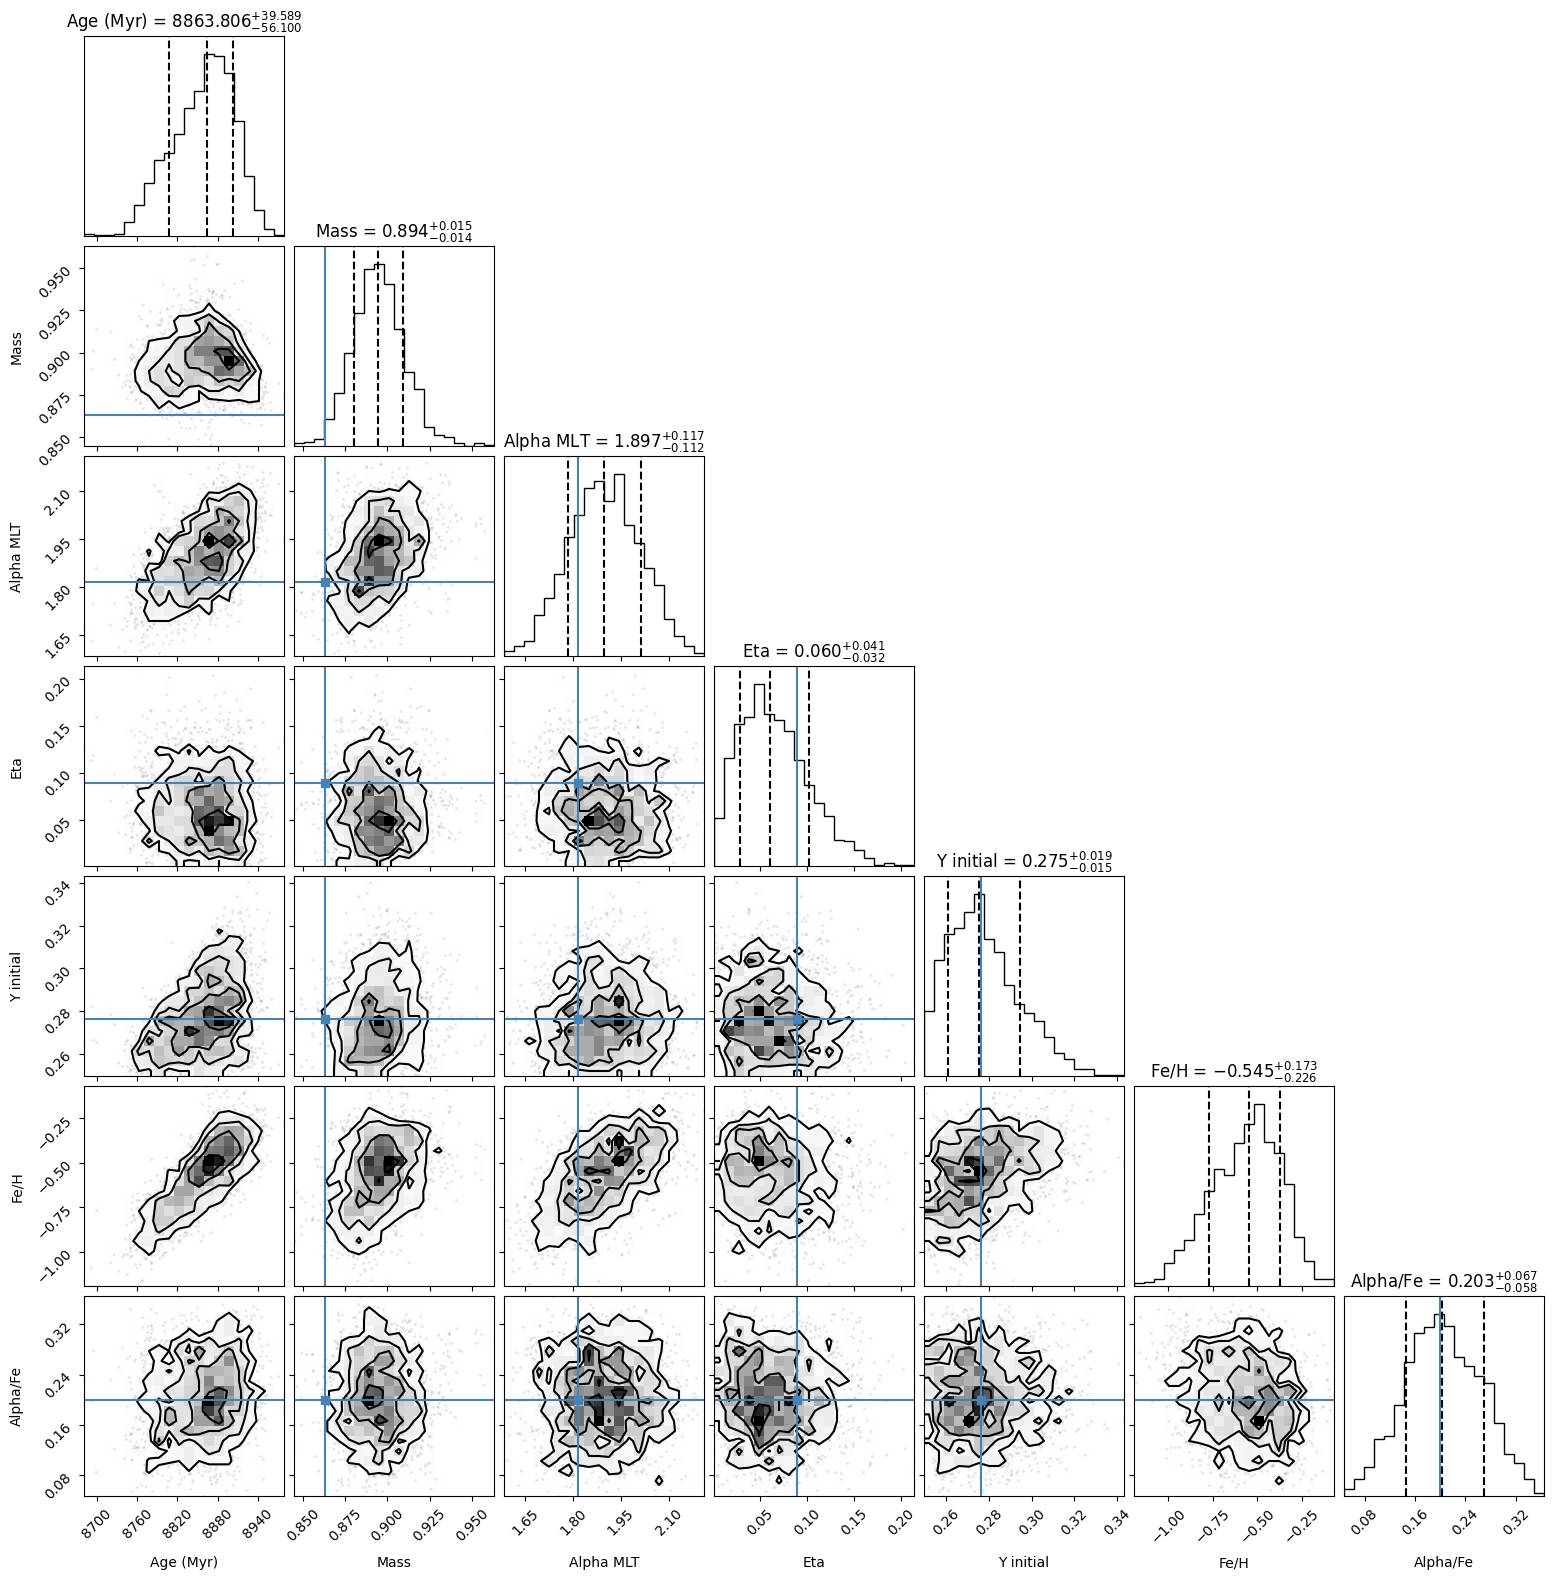

In [264]:
import corner

samples = mcmc.get_samples()

# Index

i = 3

params_of_interest = {
    'Age (Myr)': samples['ages_'][..., i],
    'Mass': samples['massini_'][..., i],
    'Alpha MLT': samples['alphamlt_'][..., i],
    'Eta': samples['eta_'][..., i],
    'Y initial': samples['yini_'][..., i],
    'Fe/H': samples['fehini_'][..., i],
    'Alpha/Fe': samples['alphafe_'][..., i]
}

# Convert to a numpy array for corner.py
X = np.column_stack([params_of_interest[key] for key in params_of_interest])
labels = list(params_of_interest.keys())


fig = corner.corner(
    X, 
    labels=labels,
    quantiles=[0.16, 0.5, 0.84],  
    show_titles=True,
    title_kwargs={"fontsize": 12},
    title_fmt='.3f',
    truths = truths[i],
)

#plt.tight_layout()
plt.show()

C:\Users\Dell\AppData\Local\Temp\ipykernel_27524\2792876347.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


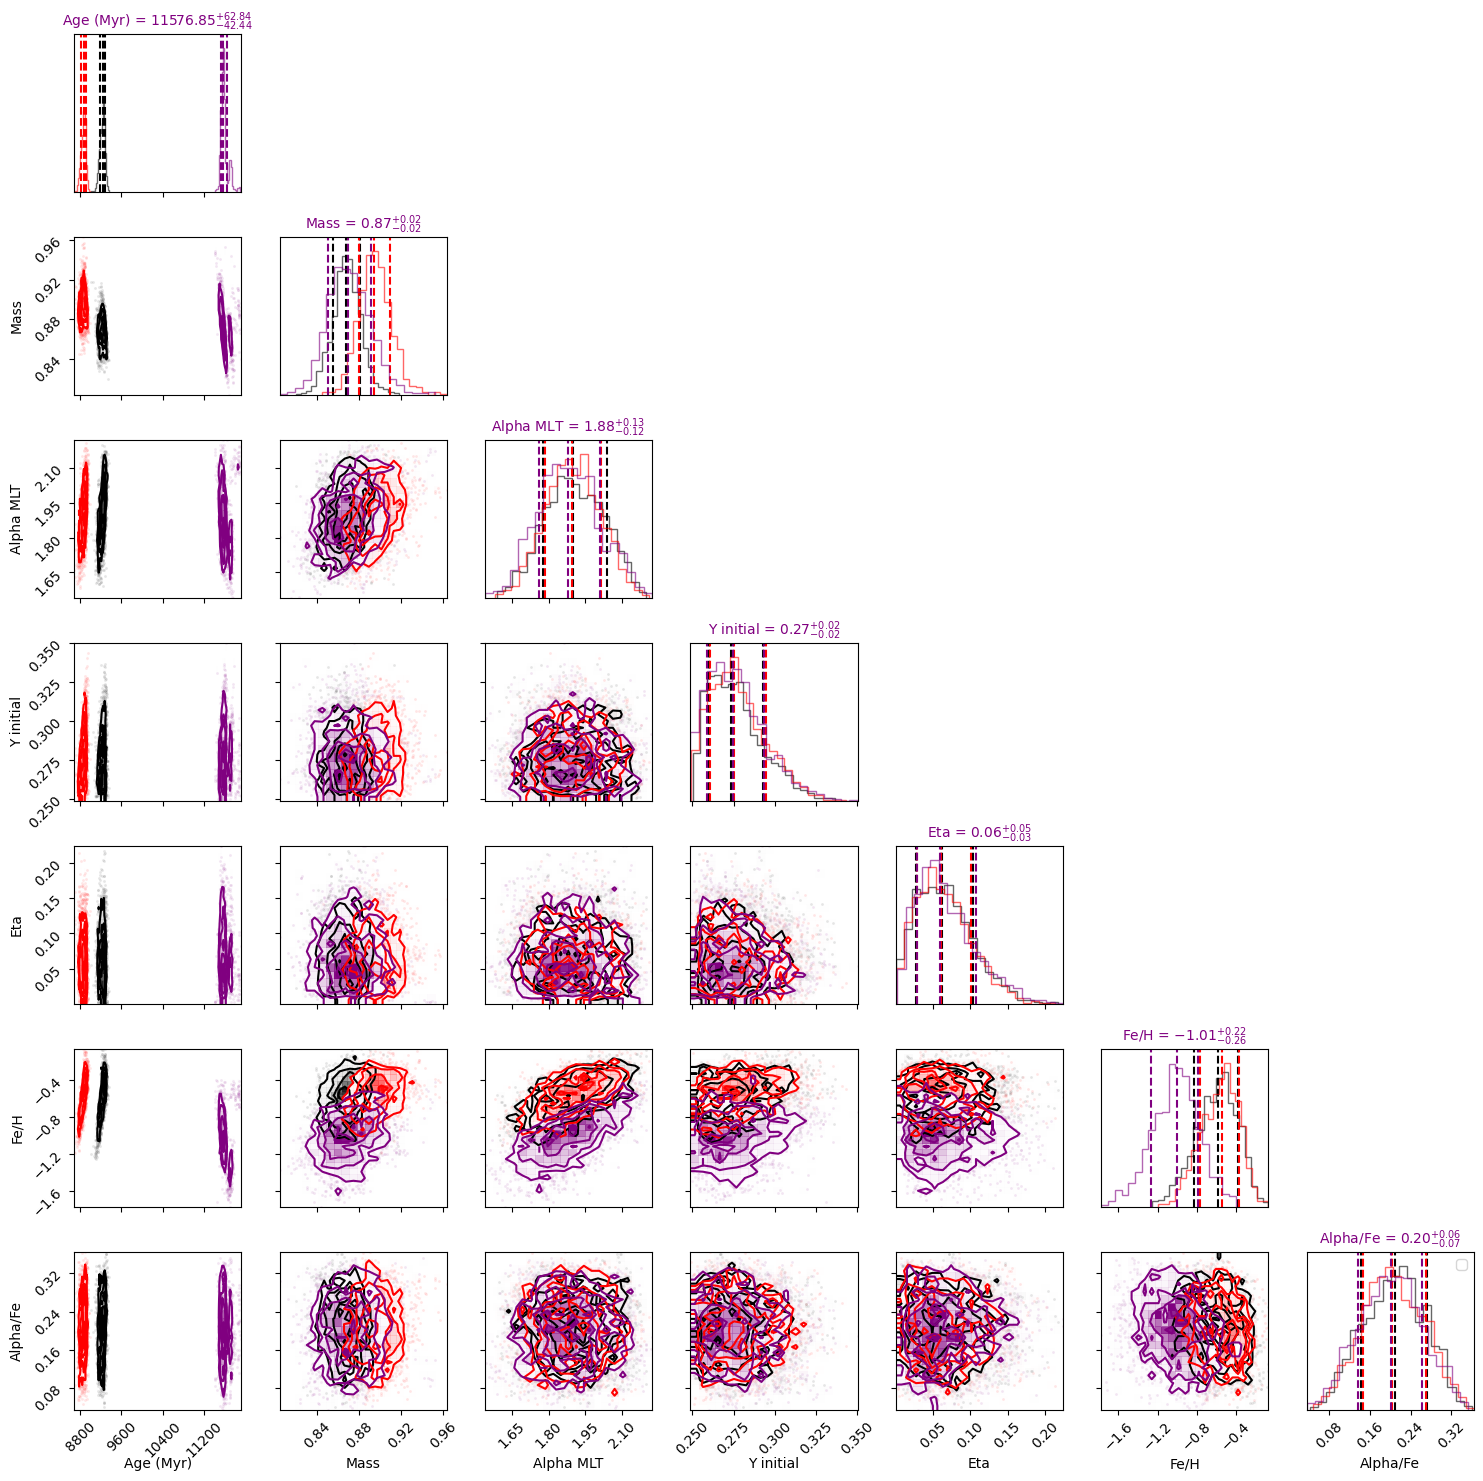

In [265]:
# Create a figure for the corner plot
fig = plt.figure(figsize=(15, 15))

# Parameters to include
params = ['ages_', 'massini_', 'alphamlt_', 'yini_', 'eta_', 'fehini_', 'alphafe_']
labels = ['Age (Myr)', 'Mass', 'Alpha MLT', 'Y initial', 'Eta', 'Fe/H', 'Alpha/Fe']

# Colors for different stars
colors = ['black', 'red', 'purple']

# Plot each star's corner plot with a different color
for star_idx in range(min(3, len(samples['ages_'][0]))):  # Plot up to 5 stars
    # Extract samples for this star
    X = np.column_stack([samples[param][..., (star_idx+2)] for param in params])
    
    # Add the corner plot for this star
    corner.corner(
        X, 
        labels=labels,
        fig=fig,
        color=colors[star_idx],
        quantiles=[0.16, 0.5, 0.84],
        show_titles=True,
        title_kwargs={"fontsize": 10, "color": colors[star_idx]},
        hist_kwargs={"alpha": 0.6},
    )

plt.tight_layout()
plt.legend()
plt.show()